In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from tqdm import tqdm

# Load dataset
data = pd.read_csv('./DatasetCombined.csv', encoding='ISO-8859-1')

# Update the LABEL mapping to handle three categories: ham, spam, smishing
data['LABEL'] = data['LABEL'].map({'ham': 0, 'spam': 1, 'smishing': 2})

# Splitting the data into features and labels
X = data['TEXT']
y = data['LABEL']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Ensure there are no NaN values in the target after splitting
y_train = y_train.dropna()
y_test = y_test.dropna()
X_train = X_train[~y_train.isna()]
X_test = X_test[~y_test.isna()]

# Re-transform the text data into TF-IDF features after removing NaN values
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Hyperparameter grids for tuning
param_distributions_lr = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

param_distributions_rf = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

# Models setup with hyperparameter tuning
models = {
    'Logistic Regression': RandomizedSearchCV(LogisticRegression(), param_distributions_lr, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Random Forest': RandomizedSearchCV(RandomForestClassifier(), param_distributions_rf, n_iter=10, cv=3, random_state=42, scoring='accuracy'),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier()
}

# Train and evaluate models
results = {}
for model_name, model in tqdm(models.items(), desc='Training Models'):
    model.fit(X_train_tfidf, y_train)
    best_model = model.best_estimator_ if 'RandomizedSearchCV' in str(model) else model
    y_pred = best_model.predict(X_test_tfidf)
    y_prob = best_model.predict_proba(X_test_tfidf) if hasattr(best_model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    # For multi-class ROC, we'll need to adjust the ROC curve computation
    roc_auc = {}
    if y_prob is not None:
        for i in range(3):  # There are three classes
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=i)
            roc_auc[i] = {'fpr': fpr, 'tpr': tpr, 'auc': auc(fpr, tpr)}

    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_prob': y_prob  # Storing probabilities for later use
    }




Training Models:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\lvimukthi\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ 

In [2]:
# Convert results to a DataFrame for better readability
comparison = pd.DataFrame(results).T[['accuracy', 'precision', 'recall', 'f1']]
print(comparison)





                     accuracy precision    recall        f1
Logistic Regression  0.958333  0.955998  0.958333  0.956989
Random Forest        0.931818    0.9216  0.931818  0.918813
Decision Tree        0.964161  0.960389  0.964161   0.96083
SVM                  0.967366    0.9668  0.967366  0.962127
KNN                  0.914336  0.898615  0.914336  0.900137


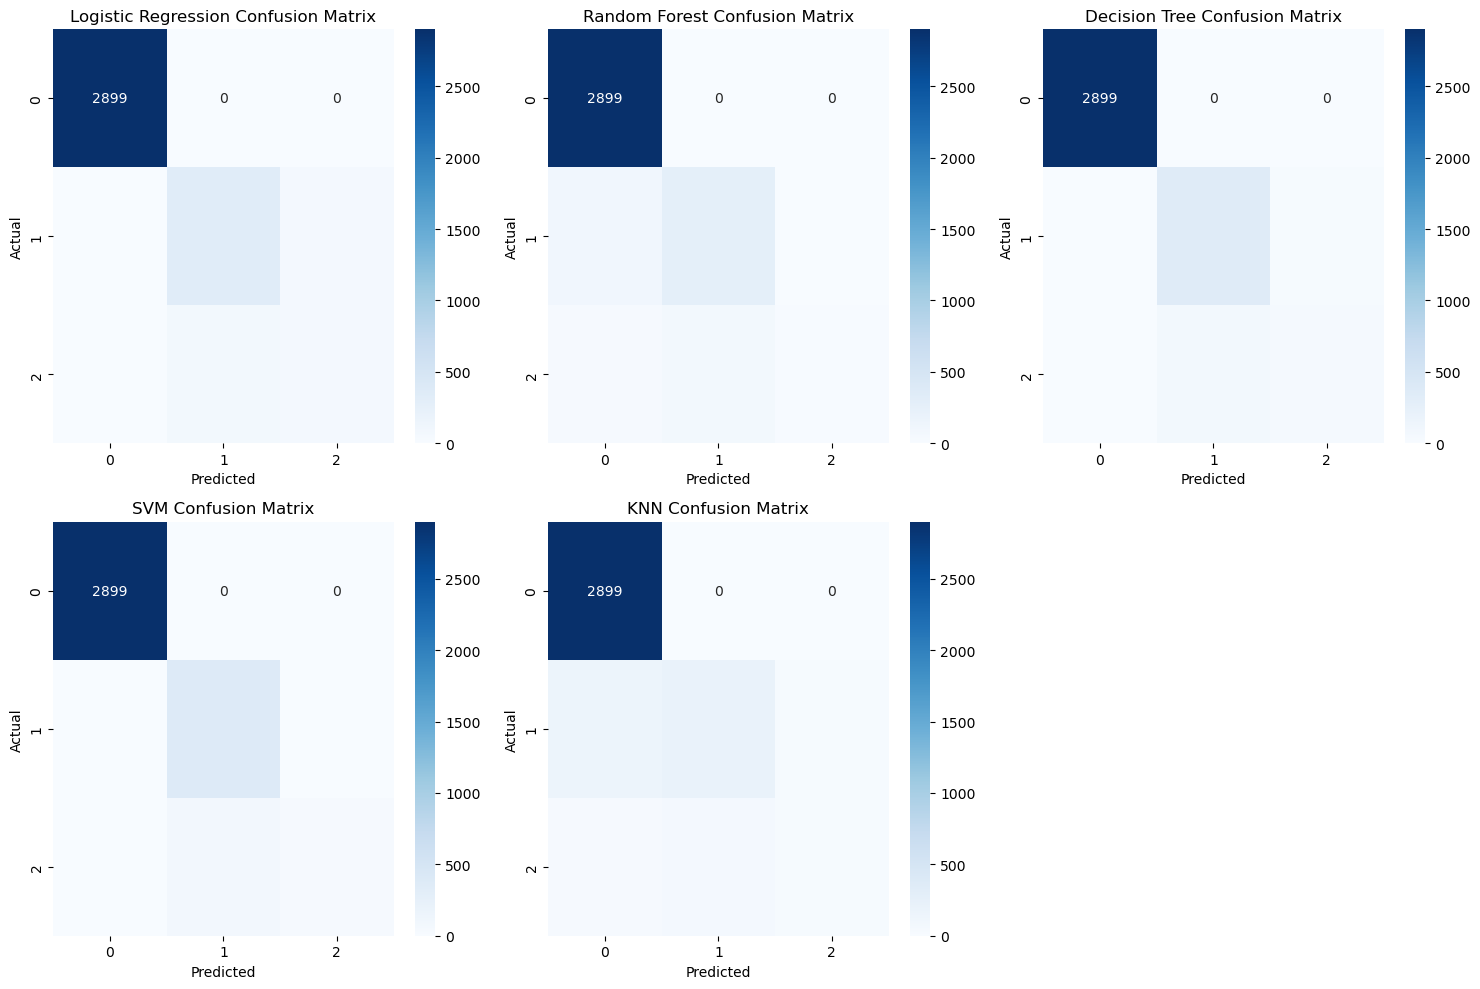

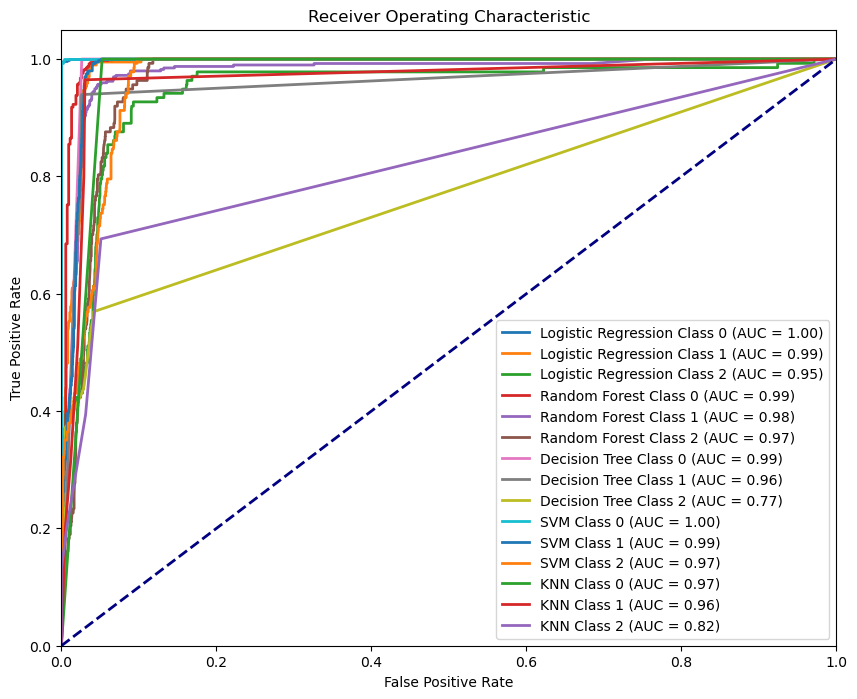

In [3]:
# Plotting function
def plot_metrics(results):
    plt.figure(figsize=(15, 10))

    # Confusion Matrices
    for i, (model_name, result) in enumerate(results.items(), 1):
        plt.subplot(2, 3, i)
        cm = confusion_matrix(y_test, models[model_name].predict(X_test_tfidf))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 8))
    for model_name, result in results.items():
        if result['roc_auc']:
            for i in range(3):  # Plotting for each class
                plt.plot(result['roc_auc'][i]['fpr'], result['roc_auc'][i]['tpr'], lw=2, 
                         label=f'{model_name} Class {i} (AUC = {result["roc_auc"][i]["auc"]:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Plot results
plot_metrics(results)

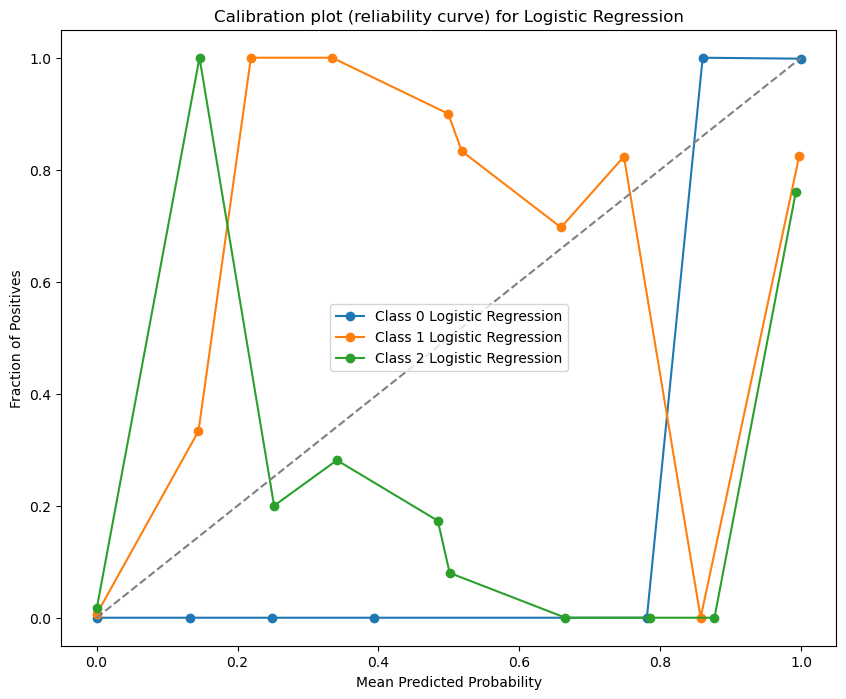

Brier score for Logistic Regression, class 0: 0.0017
Brier score for Logistic Regression, class 1: 0.0334
Brier score for Logistic Regression, class 2: 0.0324


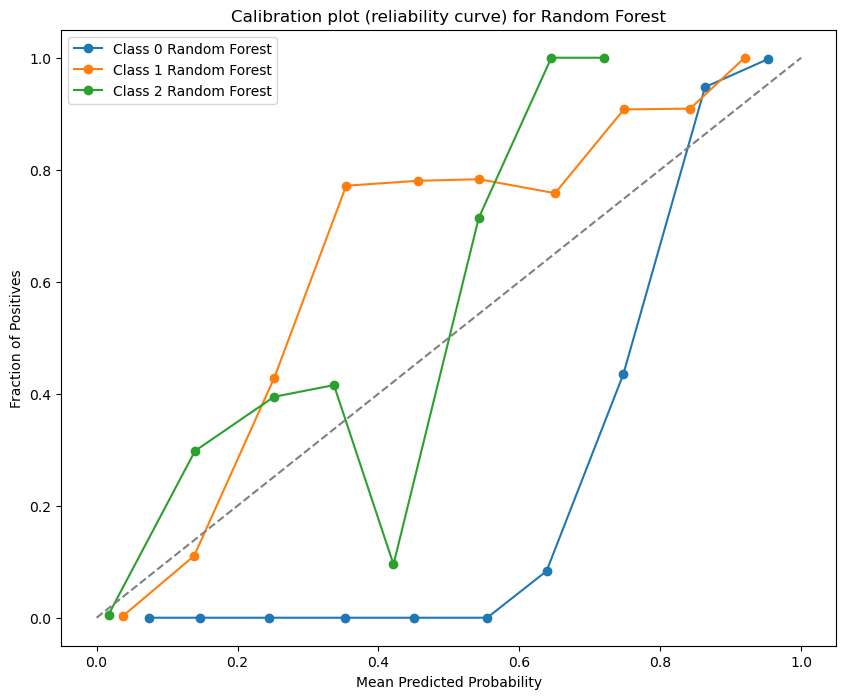

Brier score for Random Forest, class 0: 0.0274
Brier score for Random Forest, class 1: 0.0404
Brier score for Random Forest, class 2: 0.0268


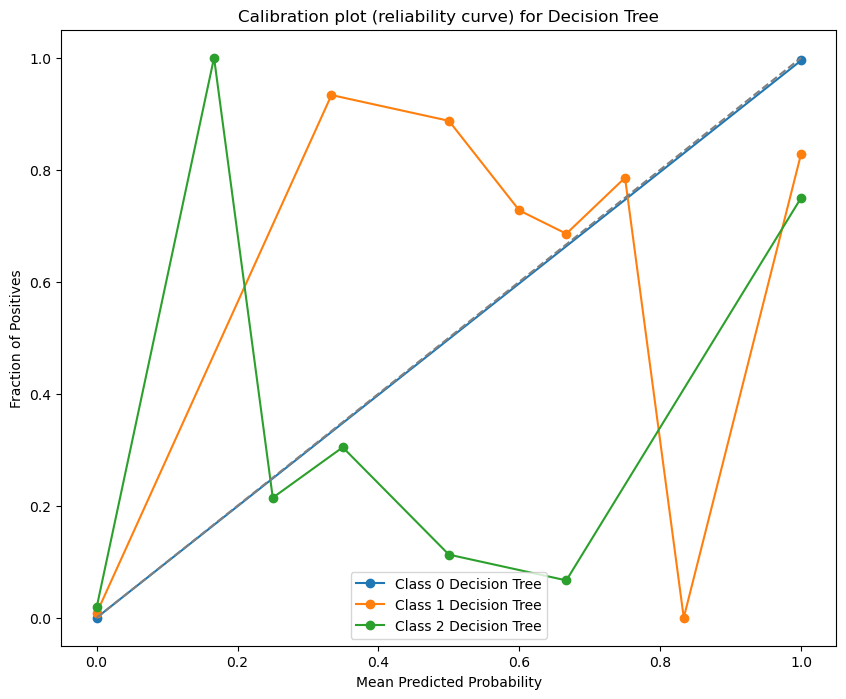

Brier score for Decision Tree, class 0: 0.0041
Brier score for Decision Tree, class 1: 0.0329
Brier score for Decision Tree, class 2: 0.0329


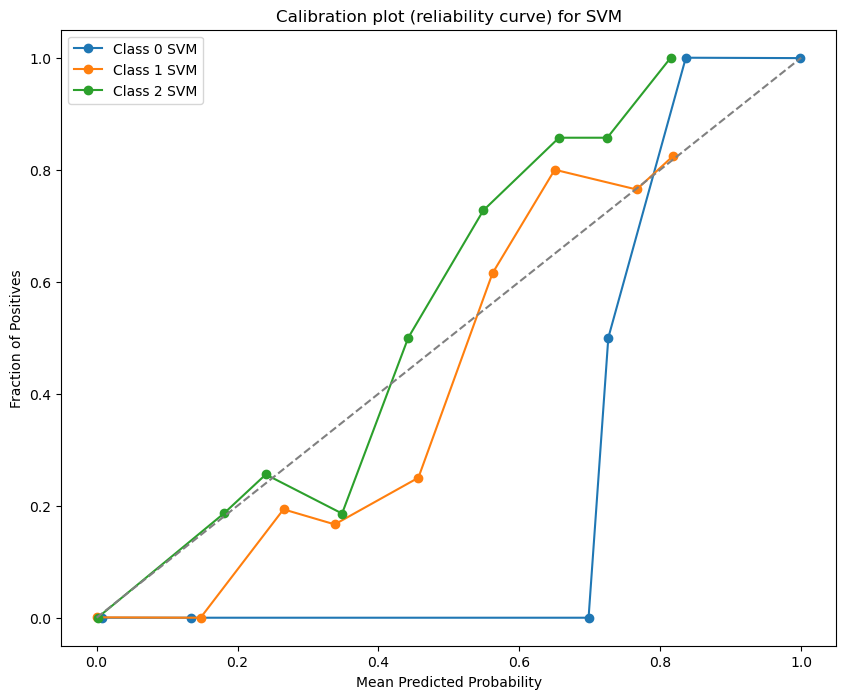

Brier score for SVM, class 0: 0.0010
Brier score for SVM, class 1: 0.0249
Brier score for SVM, class 2: 0.0240


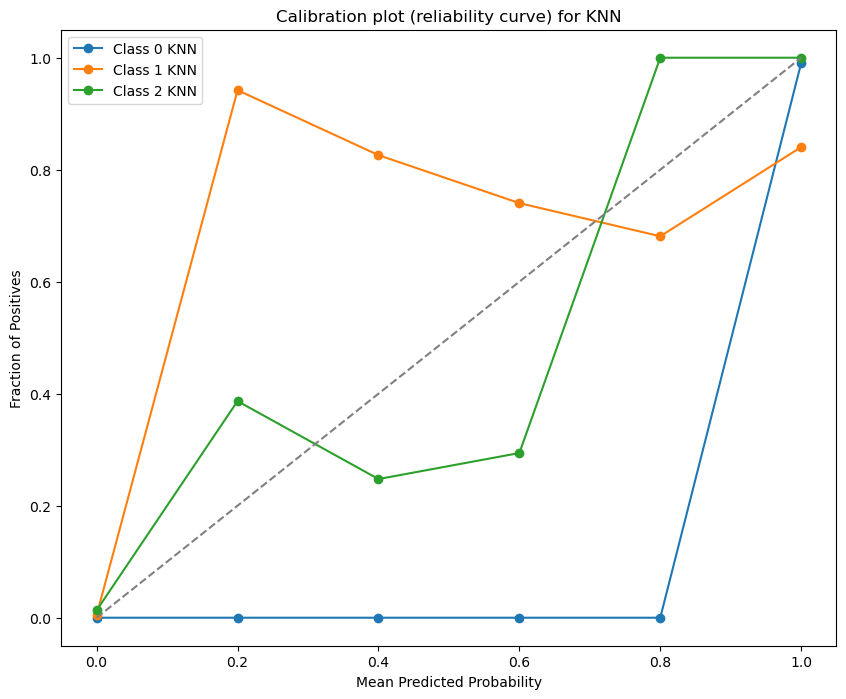

Brier score for KNN, class 0: 0.0305
Brier score for KNN, class 1: 0.0448
Brier score for KNN, class 2: 0.0301


In [4]:
# Testing probability calibration and Brier scores
for model_name, model in models.items():
    if results[model_name]['y_prob'] is not None:
        y_prob = results[model_name]['y_prob']
        
        # Calibration plot (reliability curve)
        plt.figure(figsize=(10, 8))
        for i in range(3):  # Assuming three classes
            prob_true, prob_pred = calibration_curve((y_test == i).astype(int), y_prob[:, i], n_bins=10)
            plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i} {model_name}')
        
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title(f'Calibration plot (reliability curve) for {model_name}')
        plt.legend()
        plt.show()
        
        # Brier score
        for i in range(3):  # Assuming three classes
            brier_score = brier_score_loss((y_test == i).astype(int), y_prob[:, i])
            print(f'Brier score for {model_name}, class {i}: {brier_score:.4f}')



In [5]:
# Cross-validation for each model
for model_name, model in models.items():
    best_model = model.best_estimator_ if 'RandomizedSearchCV' in str(model) else model
    
    # Perform cross-validation
    cv_scores = cross_val_score(best_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
    print(f'{model_name} Cross-validation accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')


Logistic Regression Cross-validation accuracy: 0.9537 ± 0.0041
Random Forest Cross-validation accuracy: 0.9278 ± 0.0029
Decision Tree Cross-validation accuracy: 0.9553 ± 0.0031
SVM Cross-validation accuracy: 0.9554 ± 0.0024
KNN Cross-validation accuracy: 0.9072 ± 0.0029
